In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# switch to the project directory
%cd ..
# working directory should be ../pdi

/home/mytkom/Documents/alice/pdi


In [3]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
from pdi.constants import PART_NAME_TO_TARGET_CODE

MODELS = {
    "Run7": "results/attention_hyperparameter_tuning/kaon/run_7_old_bunny",
    "Run8": "results/attention_hyperparameter_tuning/kaon/run_8_old_bunny",
}
target_code = PART_NAME_TO_TARGET_CODE["kaon"]

save_dir = "reports"
os.makedirs(save_dir, exist_ok=True)

In [5]:
import json
from pdi.config import Config
from pdi.engines import build_engine
from pdi.engines.base_engine import TestResults

test_results: dict[str, TestResults] = {}
for k, v in MODELS.items():
    with open(f"{v}/config.json", 'r') as f:
        config_data = json.load(f)
    config = Config.from_dict(config_data)
    config.training.device = "cpu"
    engine = build_engine(config, target_code)
    test_results[k] = engine.test(model_dirpath=f"{v}/model_weights")

[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: d293b2e3d00b17039949c132888b4b4b
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.


100%|██████████| 74/74 [01:07<00:00,  1.09it/s]


Test results:
{'f1': 0.0882202052091555, 'precision': 0.04939485502483, 'recall': 0.4122827239614551, 'loss': 0.15915458065432472, 'threshold': 0.029322028, 'target_code': 321}
[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: d293b2e3d00b17039949c132888b4b4b
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.


100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Test results:
{'f1': 0.0882202052091555, 'precision': 0.04939485502483, 'recall': 0.4122827239614551, 'loss': 0.15915458065432472, 'threshold': 0.029322028, 'target_code': 321}


In [8]:
import pandas as pd

# Extract metrics from test_results
metrics_data = []
for model_name, test_result in test_results.items():
    metrics = test_result.test_metrics.to_dict()  # Assuming `metrics` is a dictionary of test metrics
    metrics['Model'] = model_name
    metrics_data.append(metrics)

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Save as LaTeX table
latex_table = metrics_df.to_latex(index=False)
with open(f"{save_dir}/test_metrics_comparison.tex", "w") as f:
    f.write(latex_table)

# Save as CSV file
metrics_df.to_csv(f"{save_dir}/test_metrics_comparison.csv", index=False)

print("LaTeX table and CSV file saved successfully.")

        f1  precision    recall      loss  threshold  target_code  \
0  0.08822   0.049395  0.412283  0.159155   0.029322          321   
1  0.08822   0.049395  0.412283  0.159155   0.029322          321   

             Model  
0    Example model  
1  Example model 2  
LaTeX table and CSV file saved successfully.


/tmp/ipykernel_1162197/2164369884.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics_df.to_latex(index=False)


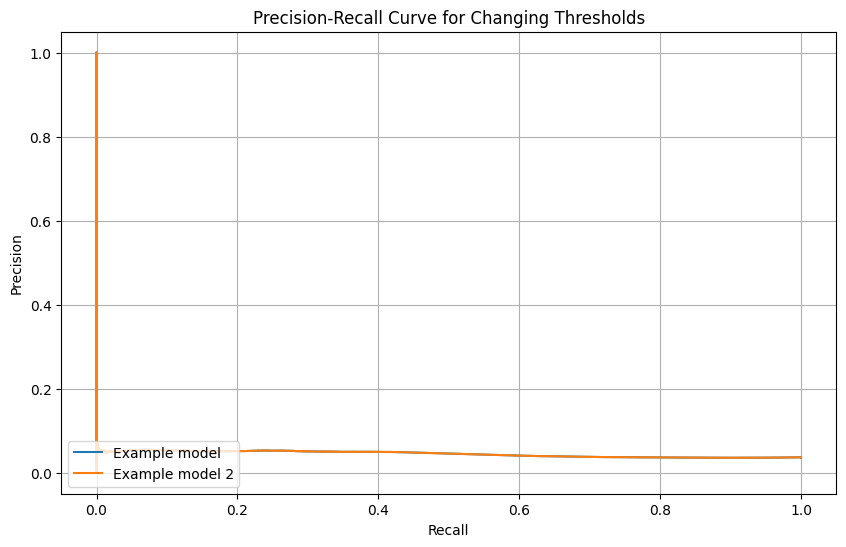

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Generate precision-recall curves for all models
plt.figure(figsize=(10, 6))
for model_name, test_result in test_results.items():
    binary_targets = test_result.targets == test_result.test_metrics.target_code
    precision, recall, thresholds = precision_recall_curve(binary_targets, test_result.predictions)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Changing Thresholds")
plt.legend(loc="lower left")
plt.grid()
plt.show()